In [1]:
%%capture
#@title NPT_TUTORIAL Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [2]:
#@title Imports & Utils

!pip install -q jax-md

import imageio
import jax.numpy as jnp
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from jax_md import space
from jax_md.colab_tools import renderer
import jax
import numpy as np

sns.set_style(style='white')
background_color = [56 / 256] * 3
colours = jnp.array([
    [125, 148, 181],
    # [200, 183, 166],
    [194, 149, 145],
    # [112, 63, 55],
    # [182, 193, 153],
]) / 255

def make_chains(box_size, num_1d, chain_length):
  _1d_pos = jnp.linspace(0, box_size, num_1d + 1)[:num_1d]
  _1d_pos += 0.5 * box_size / num_1d
  num_chains_lengthwise = num_1d // chain_length


  def chain_data(atom_index, start_x, start_y):
    chain_positions_x = start_x + jnp.linspace(
        0, box_size / num_chains_lengthwise, chain_length + 1
    )[:-1]
    chain_position_y = jnp.ones(chain_length) * start_y
    chain_positions = jnp.stack([chain_positions_x, chain_position_y]).T
    chain_bonds = jnp.stack([
        atom_index + jnp.arange(chain_length - 1),
        atom_index + jnp.arange(1, chain_length),
    ]).T
    num_chain_angle_bonds = chain_length - 2
    chain_angle_bonds = jnp.stack([
        atom_index + jnp.arange(0, chain_length - 2),
        atom_index + jnp.arange(1, chain_length - 1),
        atom_index + jnp.arange(2, chain_length - 0),
    ]).T
    species = [0, 0, 1]
    chain_angle_species = jnp.array(species, dtype=jnp.int32)
    atom_species = jnp.array([0] + species + [0], dtype=jnp.int32)
    chain_atom_colors = colours[atom_species]
    return (
        jnp.mod(chain_positions, box_size),
        chain_bonds,
        chain_angle_bonds,
        chain_angle_species,
        chain_atom_colors,
    )


  def make_row_of_chains(atom_index, start_y):
    start_y = start_y.repeat(num_chains_lengthwise)
    atom_indices = atom_index + jnp.arange(num_chains_lengthwise) * chain_length
    start_x = _1d_pos[::chain_length] + 2 * start_y
    out = jax.vmap(chain_data)(atom_indices, start_x, start_y)
    reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
    return jax.tree_map(reshape, out)

  row = jax.vmap(make_row_of_chains)(num_1d * jnp.arange(num_1d), _1d_pos)
  reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
  return jax.tree_map(reshape, row)

def plot_chains(pos, rad, colors, size=800):
  return renderer.render(
      box_size,
      {
          'chains': renderer.Disk(
              pos,
              jnp.ones(positions.shape[0]) * rad,
              color=colors,
          ),
      },
      resolution=(size, size),
  )

In [3]:
#@title SMAP Bond Angles
from jax_md.smap import _kwargs_to_bond_parameters, high_precision_sum
from typing import Callable, Optional, Dict, Union
from jax_md import util
from functools import partial

Array = util.Array

DisplacementOrMetricFn = space.DisplacementOrMetricFn

f32 = util.f32


# LR: edited jax_md.smap.bond, this is intended to work on an array with all
# atoms with two bonds
def bond_angles(fn: Callable[..., Array],
         displacement_or_metric: DisplacementOrMetricFn,
         static_bonds: Optional[Array]=None,
         static_bond_types: Optional[Array]=None,
         ignore_unused_parameters: bool=False,
         **kwargs) -> Callable[..., Array]:
  """Promotes a function that acts on a single pair to one on a set of bonds.

  TODO(schsam): It seems like bonds might potentially have poor memory access.
  Should think about this a bit and potentially optimize.

  Args:
    fn: A function that takes an ndarray of pairwise distances or displacements
      of shape `[n, m]` or `[n, m, d_in]` respectively as well as kwargs
      specifying parameters for the function. `fn` returns an ndarray of
      evaluations of shape `[n, m, d_out]`.
    metric: A function that takes two ndarray of positions of shape
      `[spatial_dimension]` and `[spatial_dimension]` respectively and returns
      an ndarray of distances or displacements of shape `[]` or `[d_in]`
      respectively. The metric can optionally take a floating point time as a
      third argument.
    static_bonds: An ndarray of integer pairs wth shape `[b, 2]` where each
      pair specifies a bond. `static_bonds` are baked into the returned compute
      function statically and cannot be changed after the fact.
    static_bond_types: An ndarray of integers of shape `[b]` specifying the
      type of each bond. Only specify bond types if you want to specify bond
      parameters by type. One can also specify constant or per-bond parameters
      (see below).
    ignore_unused_parameters: A boolean that denotes whether dynamically
      specified keyword arguments passed to the mapped function get ignored
      if they were not first specified as keyword arguments when calling
      `smap.bond(...)`.
    kwargs: Arguments providing parameters to the mapped function. In cases
      where no bond type information is provided these should be either

        1. a scalar
        2. an ndarray of shape `[b]`.

      If bond type information is provided then the parameters should be
      specified as either

        1. a scalar
        2. an ndarray of shape `[max_bond_type]`.
        3. a ParameterTree containing a PyTree of parameters and a mapping. See
           ParameterTree for details.
  Returns:
    A function `fn_mapped`. Note that `fn_mapped` can take arguments bonds and
    `bond_types` which will be bonds that are specified dynamically. This will
    incur a recompilation when the number of bonds changes. Improving this
    state of affairs I will leave as a TODO until someone actually uses this
    feature and runs into speed issues.
  """

  # Each call to vmap adds a single batch dimension. Here, we would like to
  # promote the metric function from one that computes the distance /
  # displacement between two vectors to one that acts on two lists of vectors.
  # Thus, we apply a single application of vmap.

  merge_dicts = partial(util.merge_dicts,
                        ignore_unused_parameters=ignore_unused_parameters)

  def compute_fn(R, bonds, bond_types, static_kwargs, dynamic_kwargs):
    Ra = R[bonds[:, 0]]
    Rb = R[bonds[:, 1]]
    Rc = R[bonds[:, 2]]
    _kwargs = merge_dicts(static_kwargs, dynamic_kwargs)
    _kwargs = _kwargs_to_bond_parameters(bond_types, _kwargs)
    # NOTE(schsam): This pattern is needed due to JAX issue #912.
    d = jax.vmap(partial(displacement_or_metric, **dynamic_kwargs), 0, 0)
    dr = d(Ra, Rb, Rc)
    return high_precision_sum(fn(dr, **_kwargs))

  def mapped_fn(R: Array,
                bonds: Optional[Array]=None,
                bond_types: Optional[Array]=None,
                **dynamic_kwargs) -> Array:
    accum = f32(0)

    if bonds is not None:
      accum = accum + compute_fn(R, bonds, bond_types, kwargs, dynamic_kwargs)

    if static_bonds is not None:
      accum = accum + compute_fn(
          R, static_bonds, static_bond_types, kwargs, dynamic_kwargs)

    return accum
  return mapped_fn

In [4]:
#@title Chain Energy
from jax_md import smap


def chain_energy_components(displacement_fn, chain_hyp):
  def bond(r):
    return chain_hyp.k_r * (r - chain_hyp.r_eq) ** 2

  def bond_angle_energy(theta, species):
    return chain_hyp.k_theta * (theta - chain_hyp.theta_eq[species]) ** 2

  eps = 1e-4
  def angle_metric(ra, rb, rc):
    rab = displacement_fn(rb, ra)
    rbc = displacement_fn(rc, rb)
    rab /= jnp.linalg.norm(rab)
    rbc /= jnp.linalg.norm(rbc)
    sin = rab[0] * rbc[1] - rbc[0] * rab[1]
    cos = rab[0] * rbc[0] + rab[1] * rbc[1]
    return jnp.arctan2(sin, cos)

  def non_bonded(rs):
    return energy.soft_sphere(
        rs, sigma=chain_hyp.radius, epsilon=chain_hyp.strength
    )

  return {
      "bond": {"energy": bond, "metric": displacement_fn},
      "angle": {"energy": bond_angle_energy, "metric": angle_metric},
      "non_bonded": {"energy": non_bonded, "metric": displacement_fn}
  }


def create_chain_energy(energy_functions):

  def bond_energy(pos):
    bond_functions = energy_functions["bond"]
    bond_type = None
    return smap.bond(
      bond_functions["energy"],
      space.canonicalize_displacement_or_metric(bond_functions["metric"]),
      bonds,
      bond_type,
    )(pos)

  def angle_energy(pos):
    angle_functions = energy_functions["angle"]
    static_bond_types = None
    return bond_angles(
      partial(angle_functions["energy"], species=bond_species),
      angle_functions["metric"],
      bonds_for_angle,
      static_bond_types,
    )(pos)

  # def softsphere(positions):
  #   return energy.soft_sphere_pair(
  #       displacement_fn, sigma=radius, epsilon=strength
  #   )(positions)

  def soft_sphere(pos):
    non_bonded_functions = energy_functions["non_bonded"]
    return smap.pair(
      non_bonded_functions["energy"],
      space.canonicalize_displacement_or_metric(non_bonded_functions["metric"]),
    )(pos)

  def total_chain_energy(positions):
    return (
        soft_sphere(positions) + bond_energy(positions) + angle_energy(positions)
    )
  return total_chain_energy

# NVT

In [ ]:
class ChainHyp:
  strength = 100.0#1000.0
  radius = jnp.array(1.0)
  k_r = 10.0
  k_theta = 10.0
  r_eq = 1.1224594 * 1.000001
  theta_eq = jnp.array([0.0, jnp.pi * 0.5])


box_size = 100.0
displacement_fn, shift_fn = space.periodic(box_size)
positions, bonds, bonds_for_angle, bond_species, colors = make_chains(
    box_size=box_size, num_1d=40, chain_length=5
)
chain_hyp = ChainHyp()
energy_functions = chain_energy_components(displacement_fn, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)

Text(0, 0.5, '$\\epsilon$')

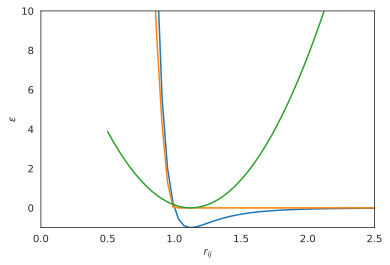

In [ ]:
#@title Bond Energies
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))
plt.plot(rs, energy_functions["non_bonded"]["energy"](rs))
plt.plot(rs, energy_functions["bond"]["energy"](rs))

plt.ylim([-1, 10])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

Text(0, 0.5, 'recovered theta')

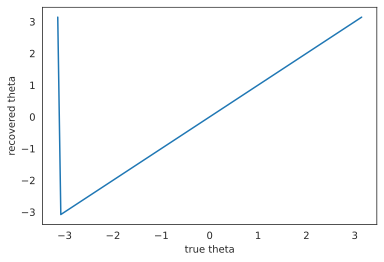

In [ ]:
#@title Angle Metric
t = jnp.linspace(-jnp.pi, jnp.pi, 100)
ra = jnp.array([0, 0])
rb = jnp.array([1, 0])
rc = jnp.array([1, 0])[None, :] + jnp.stack([jnp.cos(t), jnp.sin(t)]).T

plt.plot(t, [energy_functions["angle"]["metric"](ra, rb, rc_) for rc_ in rc])
plt.xlabel('true theta')
plt.ylabel('recovered theta')

In [ ]:
from jax_md import minimize
from jax import jit

def run_minimization(energy_fn, R_init, shift, num_steps=50):
  """Simple EM, no record"""
  dt_start = 0.001
  dt_max   = 0.004
  init, apply = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=dt_start, dt_max=dt_max
  )
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = jax.lax.scan(scan_fn,state,np.arange(num_steps))

  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position)))

k = jax.random.PRNGKey(seed=0)
# add noise to the positions
position_noise = jax.random.normal(k, shape=positions.shape) * 0.3
noisy_positions = positions + position_noise
# relax everything
positions_relaxed, max_force_component = run_minimization(
    total_chain_energy, noisy_positions, shift_fn
)

In [ ]:
#@title Standard NVT-Langevin
from jax_md import simulate
from jax_md import dataclasses
from jax import lax



@dataclasses.dataclass
class Chains:
  chains: simulate.NVTLangevinState

simulation_steps = 10000
write_every = 50
write_steps = simulation_steps // write_every

init_fn, step_fn = simulate.nvt_langevin(total_chain_energy, shift_fn, dt=5e-3, kT=0.0)


def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory
  traj = Chains(traj.chains.at[i].set(state.chains.position))

  def total_step_fn(_, state): return Chains(step_fn(state.chains))

  state = lax.fori_loop(0, write_every, total_step_fn, state)
  return state, traj

n = positions_relaxed.shape[0]

key = jax.random.PRNGKey(seed=0)

position_start = jnp.mod(positions_relaxed, box_size)

state = Chains(init_fn(key, position_start),)
trajectory = Chains(jnp.zeros((write_steps, n, 2)),)

state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (state, trajectory))
print(
    f"original positions potential energy: {total_chain_energy(positions)};\n"
    f"noisy positions potential energy: {total_chain_energy(noisy_positions)};\n"
    f"relaxed positions potential energy: {total_chain_energy(position_start)};\n"
    f"final positions potential energy: {total_chain_energy(state.chains.position)};\n"
)

plot_chains(trajectory.chains, chain_hyp.radius, colors, size=800)

original positions potential energy: 32185.155676811697;
noisy positions potential energy: 36760.75478000859;
relaxed positions potential energy: 25404.817437515754;
final positions potential energy: 56.93432833841442;



...trying the deterministic NVT simulation routine...

In [ ]:
#@title Deterministic NVT-Nose-Hoover
from jax_md import simulate
from jax_md import dataclasses
from jax import lax

class DeterministicChainHyp:
  dt = 5e-5
  kT  = 0.1
  tau = 100
dchyp = DeterministicChainHyp()

@dataclasses.dataclass
class Chains:
  chains: simulate.NVTNoseHooverState

simulation_steps = 30_000 # ~3 min for 100K steps
write_every = 100
write_steps = simulation_steps // write_every

init_fn, step_fn = simulate.nvt_nose_hoover(
    total_chain_energy,
    shift_fn,
    dt=dchyp.dt,
    kT=dchyp.kT,
    tau=dchyp.tau,
)


def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory
  traj = Chains(traj.chains.at[i].set(state.chains.position))

  def total_step_fn(_, state):
    return Chains(step_fn(state.chains))
  state = lax.fori_loop(0, write_every, total_step_fn, state)
  return state, traj


def run(start_positions):
  state, traj = lax.fori_loop(
      0,
      write_steps,
      simulation_fn,
      (
          Chains(init_fn(key, start_positions)),
          Chains(jnp.zeros((write_steps, n, 2))),
      ),
  )
  return traj

In [ ]:
n = positions_relaxed.shape[0]
key = jax.random.PRNGKey(seed=0)

In [ ]:
noisy_trajectory = run(noisy_positions)

In [ ]:
positions_relaxed, max_force_component = run_minimization(
    total_chain_energy, positions, shift_fn, num_steps=5000,
)
position_start = jnp.mod(positions_relaxed + 0.742 * box_size, box_size)

relaxed_trajectory = run(position_start)

```
Chains(chains=NVTNoseHooverState(position, momentum, force, mass, chain=NoseHooverChain(position=DeviceArray([0., 0., 0., 0., 0.], dtype=float32), momentum=DeviceArray([0., 0., 0., 0., 0.], dtype=float32), mass=DeviceArray([3.2e+06, 1.0e+03, 1.0e+03, 1.0e+03, 1.0e+03], dtype=float32), tau=DeviceArray(100., dtype=float32), kinetic_energy=DeviceArray(157.94955, dtype=float32), degrees_of_freedom=3200)))
```



In [ ]:
plot_chains(noisy_trajectory.chains, chain_hyp.radius, colors, size=800)

In [ ]:
plot_chains(relaxed_trajectory.chains, chain_hyp.radius, colors, size=800)

In [ ]:
state.mass

AttributeError: ignored

In [ ]:
#@title Full NVT Simulation Deterministic (changing temperature)

# create system
box_size = 100.0
displacement_fn, shift_fn, positions, bonds, bonds_for_angle, bond_species, colors = make_chains(
    box_size=box_size, num_1d=40, chain_length=5
)

# create energy function
class ChainHyp:
  strength = 1000.0
  radius = jnp.array(1.0)
  k_r = 10.0
  k_theta = 10.0
  r_eq = 1.1224594 * 1.000001
  theta_eq = jnp.array([0.0, jnp.pi * 0.5])
chain_hyp = ChainHyp()
energy_functions = chain_energy_components(displacement_fn, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)

class DeterministicHyp:
  dt = 5e-3
  kT_initial = 0.1
  kT_final = 0.01

dhyp = DeterministicHyp()

# create dynamic temperature, as our thermostat can adjust to this temperature
kT = lambda t: jnp.where(t < 5000.0 * dhyp.dt, dhyp.kT_initial, dhyp.kT_final)

# create the simulation function
from jax_md import simulate, energy
def wrap_energy(pos, **var_kw): return total_chain_energy(pos)
init_nvt, apply_nvt = simulate.nvt_nose_hoover(wrap_energy, shift_fn, dhyp.dt, kT(0.))
key = jax.random.PRNGKey(seed=0)
state = init_nvt(key, positions)

# minimise energy
from jax_md import minimize, quantity
from jax import jit

def run_minimization(energy_fn, R_init, shift, num_steps=50):
  """Simple EM, no record"""
  dt_start = 0.001
  dt_max   = 0.004
  init_em, apply_em = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=dt_start, dt_max=dt_max
  )
  apply_em = jit(apply_em)

  @jit
  def scan_fn(state, i):
    return apply_em(state), 0.
  state = init_em(R_init)
  state, _ = jax.lax.scan(scan_fn,state,np.arange(num_steps))
  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position)))
position, max_force_component = run_minimization(total_chain_energy, state.position, shift_fn, num_steps=5000)

# create some random velocities for each chain
state = simulate.NVTNoseHooverState(
    position=position,
    momentum=state.momentum,
    force=state.force,
    mass=state.mass,
    chain=state.chain
)

# simulate NVT
write_every = 100

def step_fn_nvt(i, state_and_log):
  state, log = state_and_log
  t = i * dhyp.dt

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(total_chain_energy, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])
  state = apply_nvt(state, kT=kT(t))
  return state, log

steps = 10000
log = {
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + state.position.shape) 
}
from jax import lax
state, log = lax.fori_loop(0, steps, step_fn_nvt, (state, log))

In [ ]:
plot_chains(log["position"], chain_hyp.radius, colors, size=800)

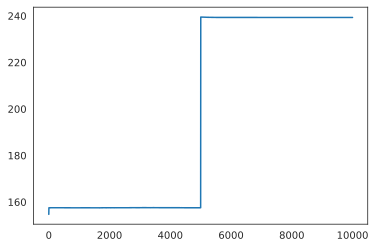

In [ ]:
plt.plot(log["H"])

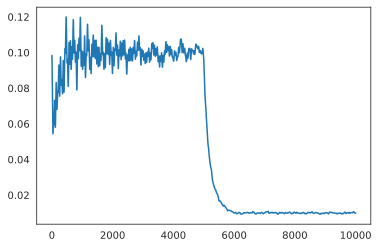

In [ ]:
plt.plot(log["kT"])

In [ ]:
# pressure = 1.0
# spatial_dim = 2

# def wrap_energy(pos, **var_kw): return total_chain_energy(pos)
# init_nvt, apply_nvt = simulate.npt_nose_hoover(
#     wrap_energy,
#     shift_fn,
#     dt=dhyp.dt,
#     pressure=pressure,
#     kT=kT(0.),
#     barostat_kwargs=None,
#     thermostat_kwargs=None,
# )

# # create some random velocities for each chain
# state = simulate.NPTNoseHooverState(
#     position=position,
#     momentum=state.momentum,
#     force=state.force,
#     mass=state.mass,
#     reference_box=,
#     box_position=(1 / spatial_dim) * np.log(V / V_0),
#     box_velocity=,
#     box_mass=,
#     barostate=,
#     thermostsat=,
# )

# NPT Chains

In [5]:
# minimise energy
from jax_md import minimize, quantity
from jax import jit

def run_minimization(energy_fn, R_init, shift, num_steps=50):
  init_em, apply_em = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=0.001, dt_max=0.004
  )
  apply_em = jit(apply_em)

  @jit
  def scan_fn(state, i):
    return apply_em(state), 0.
  state = init_em(R_init)
  state, _ = jax.lax.scan(scan_fn, state, np.arange(num_steps))
  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position)))

# create system
box_size = 60.0
chain_length = 5
positions, bonds, bonds_for_angle, bond_species, colors = make_chains(
    box_size=box_size, num_1d=40, chain_length=chain_length
)

# create energy function
class ChainHyp:
  strength = 1000.0
  radius = jnp.array(1.0)
  k_r = 10.0
  k_theta = 10.0
  r_eq = 1.1224594 * 1.000001
  theta_eq = jnp.array([0.0, jnp.pi * 0.5])

# generate initial positions
displacement_fn, shift_fn = space.periodic(box_size)
chain_hyp = ChainHyp()
energy_functions = chain_energy_components(displacement_fn, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)
position, max_force_component = run_minimization(
    total_chain_energy, positions, shift_fn, num_steps=5000
)
positions_in_unit_box = position / box_size

In [6]:
displacement, shift = space.periodic_general(box_size, fractional_coordinates=True) 
energy_functions = chain_energy_components(displacement, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)

class DeterministicHyp:
  dt = 5e-3
  kT_initial = 0.1
  kT_final = 0.01

dhyp = DeterministicHyp()

kT = jnp.float32(0.1)
P = lambda t: jnp.where(t < 100.0, 0.05, 0.15)

key = random.PRNGKey(0)

def wrap_energy(pos, box=jnp.array(1.0), **var_kw):
  # if box.ndim > 0:## hoping this box scaling will fix everything, but will be slightly confused if it does.
  #   box = jnp.diag(box)
  # return total_chain_energy(pos * box) * 1e-1 #1e-3
  return total_chain_energy(pos) * 1e-1 #1e-3

init, apply = simulate.npt_nose_hoover(wrap_energy, shift, dhyp.dt, P(0.), kT)
state = init(key, positions_in_unit_box, box_size)

# plot_chains(position, chain_hyp.radius, colors, size=800)

In [7]:
state

NPTNoseHooverState(position=DeviceArray([[0.05394736, 0.01720591],
             [0.07207345, 0.0125775 ],
             [0.09019954, 0.0079491 ],
             ...,
             [0.91519954, 0.9829491 ],
             [0.93332562, 0.9783207 ],
             [0.93795403, 0.99644679]], dtype=float64), momentum=DeviceArray([[-0.20226309, -0.34257774],
             [ 0.18568311,  0.01436267],
             [ 0.33267989, -0.41310599],
             ...,
             [-0.25508188,  0.32604434],
             [-0.23306589, -0.27096086],
             [-0.03043544,  0.18408372]], dtype=float64), force=DeviceArray([[-8.42204818e-16, -5.09328178e-15],
             [ 3.20569111e-15,  1.25543628e-14],
             [-8.03058139e-15, -6.32026789e-15],
             ...,
             [-2.61062866e-16,  2.41072908e-14],
             [ 3.73059421e-14, -1.30309314e-14],
             [-4.34930189e-14, -4.01944286e-15]], dtype=float64), mass=DeviceArray(1., dtype=float32), reference_box=DeviceArray([[60.,  0.],
  

Try making a state with random momenta per chain....

In [8]:
num_chains = state.position.shape[0] // chain_length

# def initialize_momenta(state: T, key: Array, kT: float) -> T:
#   """Initialize momenta with the Maxwell-Boltzmann distribution."""
#   R, mass = state.position, state.mass

#   R, treedef = tree_flatten(R)
#   mass, _ = tree_flatten(mass)
#   keys = random.split(key, len(R))

#   def initialize_fn(k, r, m):
#     p = jnp.sqrt(m * kT) * random.normal(k, r.shape, dtype=r.dtype)
#     # If simulating more than one particle, center the momentum.
#     if r.shape[0] > 1:
#       p = p - jnp.mean(p, axis=0, keepdims=True)
#     return p

#   P = [initialize_fn(k, r, m) for k, r, m in zip(keys, R, mass)]

#   return state.set(momentum=tree_unflatten(treedef, P))

key, split = random.split(key)
r = state.position
m = state.mass
per_chain_p = random.normal(split, (num_chains,) + r.shape[1:], dtype=r.dtype)
p = jnp.sqrt(m * kT) * jnp.repeat(per_chain_p, chain_length, axis=0)
p = p - jnp.mean(p, axis=0, keepdims=True)

state = state.set(momentum=p)

In [9]:
state

NPTNoseHooverState(position=DeviceArray([[0.05394736, 0.01720591],
             [0.07207345, 0.0125775 ],
             [0.09019954, 0.0079491 ],
             ...,
             [0.91519954, 0.9829491 ],
             [0.93332562, 0.9783207 ],
             [0.93795403, 0.99644679]], dtype=float64), momentum=DeviceArray([[-0.47427444,  0.45845731],
             [-0.47427444,  0.45845731],
             [-0.47427444,  0.45845731],
             ...,
             [-0.37047922, -0.18823703],
             [-0.37047922, -0.18823703],
             [-0.37047922, -0.18823703]], dtype=float64), force=DeviceArray([[-8.42204818e-16, -5.09328178e-15],
             [ 3.20569111e-15,  1.25543628e-14],
             [-8.03058139e-15, -6.32026789e-15],
             ...,
             [-2.61062866e-16,  2.41072908e-14],
             [ 3.73059421e-14, -1.30309314e-14],
             [-4.34930189e-14, -4.01944286e-15]], dtype=float64), mass=DeviceArray(1., dtype=float32), reference_box=DeviceArray([[60.,  0.],
  

In [10]:
jax.grad(total_chain_energy)(position + jax.random.normal(jax.random.PRNGKey(0), position.shape) * 0.1)

DeviceArray([[-225.58467351,  241.17986211],
             [ 289.77058037, -158.66972364],
             [-305.65185947, -229.01723303],
             ...,
             [1148.60880479,  671.97900384],
             [  80.72494293,  306.27066748],
             [  25.82522279, -275.04793629]], dtype=float64)

In [11]:
def debug_compute_potential_energy_components(positions, include_mask):
  def individual_non_bonded_energies(pos):
    """sum over energies of all other particles"""
    non_bonded_functions = energy_functions["non_bonded"]
    pair_disp = jax.vmap(
        jax.vmap(non_bonded_functions["metric"], in_axes=(0, None)),
        in_axes=(None, 0)
    )(pos, pos)
    non_bonded_energies = non_bonded_functions["energy"](pair_disp).sum(-1)
    # remove self-interactions
    non_bonded_energies = jnp.eye(pos.shape[0]) * non_bonded_energies
    return non_bonded_energies

  def individual_bond_energies(pos, bonds):
    r1, r2 = pos[bonds[:, 0]], pos[bonds[:, 1]]
    bond_functions = energy_functions["bond"]
    disps = jax.vmap(bond_functions["metric"])(r1, r2)
    dists = jnp.linalg.norm(disps, axis=-1)
    bond_energies = bond_functions["energy"](dists)
    return bond_energies

  def individual_angle_energies(pos, angle_ix):
    r1, r2, r3 = pos[angle_ix[:, 0]], pos[angle_ix[:, 1]], pos[angle_ix[:, 2]]
    angle_functions = energy_functions["angle"]
    disp = jax.vmap(angle_functions["metric"])(r1, r2, r3)
    angle_energies = angle_functions["energy"](disp, bond_species)
    return angle_energies

  non_bonded_energies = individual_non_bonded_energies(positions) / positions.shape[0]
  bond_energies = individual_bond_energies(positions, bonds) / 2
  angle_energies = individual_angle_energies(positions, bonds_for_angle) / 3

  bond_energy_split = jnp.zeros(positions.shape[0])
  bond_energy_split = bond_energy_split.at[bonds[:, 0]].add(bond_energies)
  bond_energy_split = bond_energy_split.at[bonds[:, 1]].add(bond_energies)

  angle_energy_split = jnp.zeros(positions.shape[0])
  angle_energy_split = angle_energy_split.at[bonds_for_angle[:, 0]].add(angle_energies)
  angle_energy_split = angle_energy_split.at[bonds_for_angle[:, 1]].add(angle_energies)
  angle_energy_split = angle_energy_split.at[bonds_for_angle[:, 2]].add(angle_energies)

  def split(mask):
    return {
        'non_bonded': (non_bonded_energies * mask).sum() / mask.sum(),
        'bonded': (bond_energy_split * mask).sum() / mask.sum(),
        'angle': (angle_energy_split * mask).sum() / mask.sum(),
    }

  return split(include_mask), split(1 - include_mask)

In [12]:
write_every = 50
@jit
def step_fn(i, state_and_log):
  state, log = state_and_log
  t = i * dhyp.dt

  unit_pos = state.position
  box = simulate.npt_box(state)
  # Record positions every `write_every` steps.
  pos = space.transform(box, unit_pos)
  edge_size = 0.1
  central_mask = jnp.prod(
      (unit_pos > edge_size) * (unit_pos < 1 - edge_size), axis=-1
  )  # indicator of whether we are at a central atom
  inc, ninc = debug_compute_potential_energy_components(pos, include_mask=central_mask)

  c = log['PE']['components']

  cnew = {
      'central': {k: v.at[i].set(inc[k]) for k, v in c['central'].items()},
      'outer': {k: v.at[i].set(ninc[k]) for k, v in c['outer'].items()}
  }
  cnew['total'] = {
      k: v.at[i].set(cnew['central'][k][i] + cnew['outer'][k][i])
      for k, v in c['total'].items()
  }
  central = sum(v[i] for v in cnew['central'].values())
  outer = sum(v[i] for v in cnew['outer'].values())
  log['PE']['components'] = cnew
  log['PE']['central'] = log['PE']['central'].at[i].set(central)
  log['PE']['outer'] = log['PE']['outer'].at[i].set(outer)
  log['PE']['total'] = log['PE']['total'].at[i].set(central + outer)
  log['PE']['total_full_function'] = log['PE']['total_full_function'].at[i].set(
      total_chain_energy(pos) / pos.shape[0]
  )

  KE = 0.5 * (state.mass ** -1) * (state.momentum ** 2).sum(-1)
  log['KE'] = {
      'overall_average': log['KE']['overall_average'].at[i].set(jnp.mean(KE)),
      'central_average': log['KE']['central_average'].at[i].set((KE * central_mask).sum() / central_mask.sum()),
      'outer_average': log['KE']['outer_average'].at[i].set((KE * (1 - central_mask)).sum() /  (1 - central_mask).sum()),
  }


  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  log["box"] = log['box'].at[i].set(box)

  KE = quantity.kinetic_energy(momentum=state.momentum)
  P_measured = quantity.pressure(wrap_energy, state.position, box, KE)
  log['P'] = log['P'].at[i].set(P_measured)

  H = simulate.npt_nose_hoover_invariant(wrap_energy, state, P(t), kT)
  log['H'] = log['H'].at[i].set(H)

  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: p.at[i // write_every].set(pos),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, pressure=P(t))
  
  return state, log

In [13]:
steps = 40_000

z = lambda: jnp.zeros((steps,))
log = {
    'PE': {
        'total': z(),
        'central': z(),
        'outer': z(),
        'components': {
            'total': {'non_bonded': z(), 'bonded': z(), 'angle': z()},
            'central': {'non_bonded': z(), 'bonded': z(), 'angle': z()}, 
            'outer': {'non_bonded': z(), 'bonded': z(), 'angle': z()},
        },
        'total_full_function': z(),
    },
    'KE': {'overall_average': z(), 'central_average': z(), 'outer_average': z()},
    'kT': z(),
    'P': z(),
    'H': z(),
    'position': jnp.zeros((steps // write_every,) + positions.shape),
    'box': jnp.zeros((steps, 2, 2)),
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

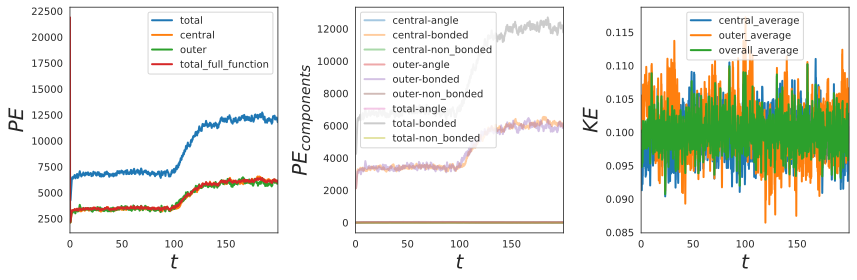

In [14]:
#@title PE KE

def detailed_plot(time_slice):
  plt.subplot(1, 3, 1)

  t = onp.arange(0, steps)[time_slice] * dhyp.dt
  pe = log['PE']
  for k in ['total', 'central', 'outer', 'total_full_function']:
    plt.plot(t, pe[k][time_slice], linewidth=2, label=k)
  plt.xlim([t[0], t[-1]])
  plt.legend()
  format_plot('$t$', '$PE$')

  plt.subplot(1, 3, 2)

  for k, v in pe['components'].items():
    for kk, vv in v.items():
      plt.plot(t, vv[time_slice], linewidth=2, alpha=0.4, label=f"{k}-{kk}")
  plt.xlim([t[0], t[-1]])
  plt.legend()
  format_plot('$t$', '$PE_{components}$')

  plt.subplot(1, 3, 3)

  for k, v in log['KE'].items():
    plt.plot(t, v[time_slice], linewidth=2, label=k)
  plt.xlim([t[0], t[-1]])
  plt.legend()
  format_plot('$t$', '$KE$')

  finalize_plot((2, 2 / 3))

detailed_plot(time_slice=slice(0, None, 1))

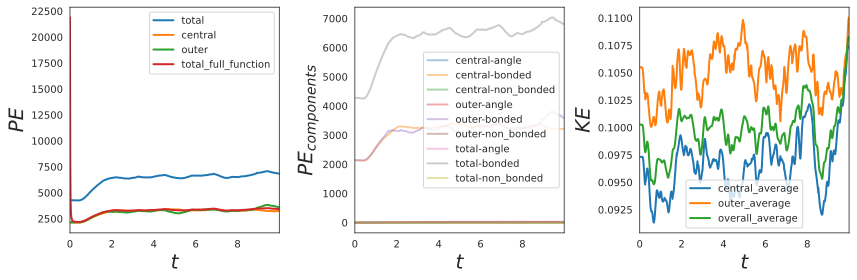

In [15]:
detailed_plot(time_slice=slice(0, 2000, 1))

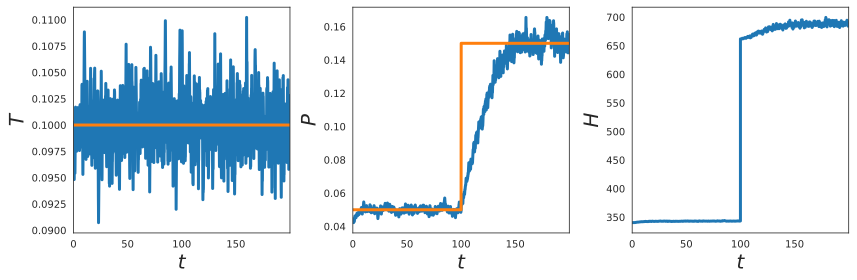

In [16]:
#@title TPH
plt.subplot(1, 3, 1)

t = onp.arange(0, steps) * dhyp.dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT * jnp.ones_like(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$T$')

plt.subplot(1, 3, 2)

t = onp.arange(0, steps) * dhyp.dt
plt.plot(t, log['P'], linewidth=3)
plt.plot(t, P(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$P$')

plt.subplot(1, 3, 3)

t = onp.arange(0, steps) * dhyp.dt
plt.plot(t, log['H'], linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$H$')

finalize_plot((2, 2 / 3))

In [21]:
log['position'].shape

(800, 1600, 2)

In [27]:
plot_chains(log["position"], chain_hyp.radius, colors, size=800)

In [26]:
log['box'][0], log['box'][-1]

(DeviceArray([[60.,  0.],
              [ 0., 60.]], dtype=float64),
 DeviceArray([[32.54368155,  0.        ],
              [ 0.        , 32.54368155]], dtype=float64))

Okay, so a few things are at play here, firstly, the starting position is geometrically perfect so has 0 force, but shifting it off slightly brings the force in, which can be too big causing Nans. Also, I'm not sure why I have to use the unit coords- because the only way I could get it to work was scaling it back to the origiinal scale in the energy function.

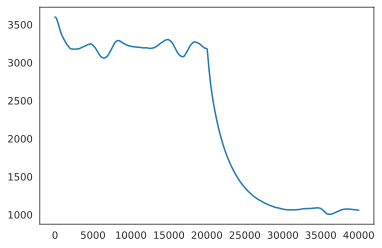

In [22]:
def area(m):
  """m: row vectors which define a basis"""
  m_2 = m.T.dot(m)
  det = jnp.linalg.det(m_2)
  return det ** 0.5

import jax
areas = jax.vmap(area)(log['box'])
plt.plot(areas)

# NPT Tutorial

The following is copied from here: https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/npt_simulation.ipynb#scrollTo=dFK0Dew5MwXt


In [ ]:
%%capture
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Pressure Simulation

Here we demonstrate some code to run a simulation at in the NPT ensemble with constant temperature and pressure. We start off by setting up some parameters of the simulation. This will include a pressure schedule that will start off at a relatively low pressure before instantaneously trippling the pressure. 

Note that unlike in the case of NVT and NVE simulations, NPT simulations must be performed with `periodic_general` boundary conditions. For now NPT simulations must be performed with fractional coordinates, where the atom positions are stored in the unit cube. This restriction can likely be relaxed in the future, if it were desirable.

In [ ]:
N = 400
dimension = 2
box = quantity.box_size_at_number_density(N, 0.8, 2)
dt = 5e-3
displacement, shift = space.periodic_general(box) 

kT = jnp.float32(0.01)
P = lambda t: jnp.where(t < 100.0, 0.05, 0.15)

In [ ]:
box

DeviceArray(22.36067977, dtype=float64, weak_type=True)

----

DEBUG


In [ ]:
# create system
box_size = 60.0
chain_length = 5
displacement_fn, shift_fn = space.periodic(box_size)
positions, bonds, bonds_for_angle, bond_species, colors = make_chains(
    box_size=box_size, num_1d=40, chain_length=chain_length
)
positions_in_unit_box = positions / box_size

# create energy function
class ChainHyp:
  strength = 1000.0
  radius = jnp.array(1.0)
  k_r = 10.0
  k_theta = 10.0
  r_eq = 1.1224594 * 1.000001
  theta_eq = jnp.array([0.0, jnp.pi * 0.5])
chain_hyp = ChainHyp()
energy_functions = chain_energy_components(displacement_fn, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)

In [ ]:
positions

DeviceArray([[ 2.25,  0.75],
             [ 3.75,  0.75],
             [ 5.25,  0.75],
             ...,
             [54.75, 59.25],
             [56.25, 59.25],
             [57.75, 59.25]], dtype=float64)

In [ ]:
plot_chains(positions, chain_hyp.radius, colors, size=800)

----

Next we need to generate some random positions as well as particle sizes. Because we are using `periodic_general` boundary conditions with fractional coordinates, we produce initial particle positions in the unit cube.

In [ ]:
key = random.PRNGKey(0)

In [ ]:
key, split = random.split(key)
R = random.uniform(split, (N, dimension), dtype=jnp.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [ ]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.npt_nose_hoover(energy_fn, shift, dt, P(0.), kT)
state = init(key, R, box)

In [ ]:
for k, v in state.__dict__.items():
  print(f"{k}: {str(v)[:100]}")

position: [[0.72536072 0.84204865]
 [0.76558029 0.44828243]
 [0.59712204 0.56627538]
 [0.87479228 0.55735807]

momentum: [[ 1.21420444e-01 -3.68517661e-02]
 [-6.16976300e-02 -8.86600150e-02]
 [ 1.83822906e-01  8.03951975e
force: [[-3.85335781e-01 -7.10736994e-01]
 [-3.99989305e-02  6.70909767e-02]
 [ 5.03714211e-01  2.60634797e
mass: 1.0
reference_box: [[22.36067977  0.        ]
 [ 0.         22.36067977]]
box_position: 0.0
box_momentum: 0.0
box_mass: 200.49998474121094
barostat: NoseHooverChain(position=DeviceArray([0., 0., 0.], dtype=float64), momentum=DeviceArray([0., 0., 0.]
thermostat: NoseHooverChain(position=DeviceArray([0., 0., 0.], dtype=float64), momentum=DeviceArray([0., 0., 0.]


Now let's actually do the simulation. To do this we'll write a small function that performs a single step of the simulation. This function will keep track of the temperature, the extended Hamiltonian of the Nose-Hoover dynamics, and the current particle positions.

In [ ]:
write_every = 100

def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)

  box = simulate.npt_box(state)
  KE = quantity.kinetic_energy(momentum=state.momentum)
  P_measured = quantity.pressure(energy_fn, state.position, box, KE)
  log['P'] = log['P'].at[i].set(P_measured)

  H = simulate.npt_nose_hoover_invariant(energy_fn, state, P(t), kT)
  log['H'] = log['H'].at[i].set(H)
  
  # Record positions every `write_every` steps.
  pos = space.transform(box, state.position)
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: p.at[i // write_every].set(pos),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, pressure=P(t))
  
  return state, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [ ]:
steps = 40000

log = {
    'kT': jnp.zeros((steps,)),
    'P': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

Now, let's plot the temperature, pressure, and hamiltonian as a function of time. We see that the temperature and pressure track the target with some fluctuations. The Hamiltonian is exactly invariant apart from the point where the target pressure is changed discontinuously.

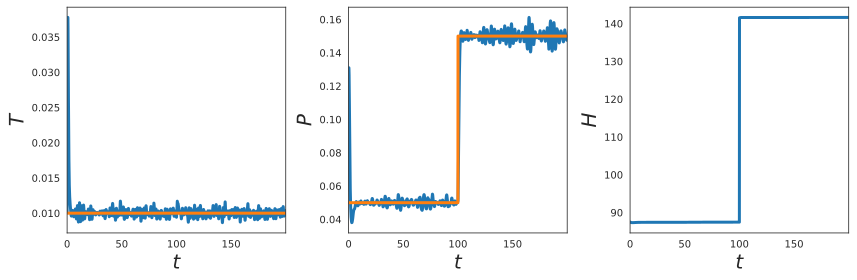

In [ ]:
plt.subplot(1, 3, 1)

t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT * jnp.ones_like(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$T$')

plt.subplot(1, 3, 2)

t = onp.arange(0, steps) * dt
plt.plot(t, log['P'], linewidth=3)
plt.plot(t, P(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$P$')

plt.subplot(1, 3, 3)

t = onp.arange(0, steps) * dt
plt.plot(t, log['H'], linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$H$')

finalize_plot((2, 2 / 3))

Now let's plot a snapshot of the system.

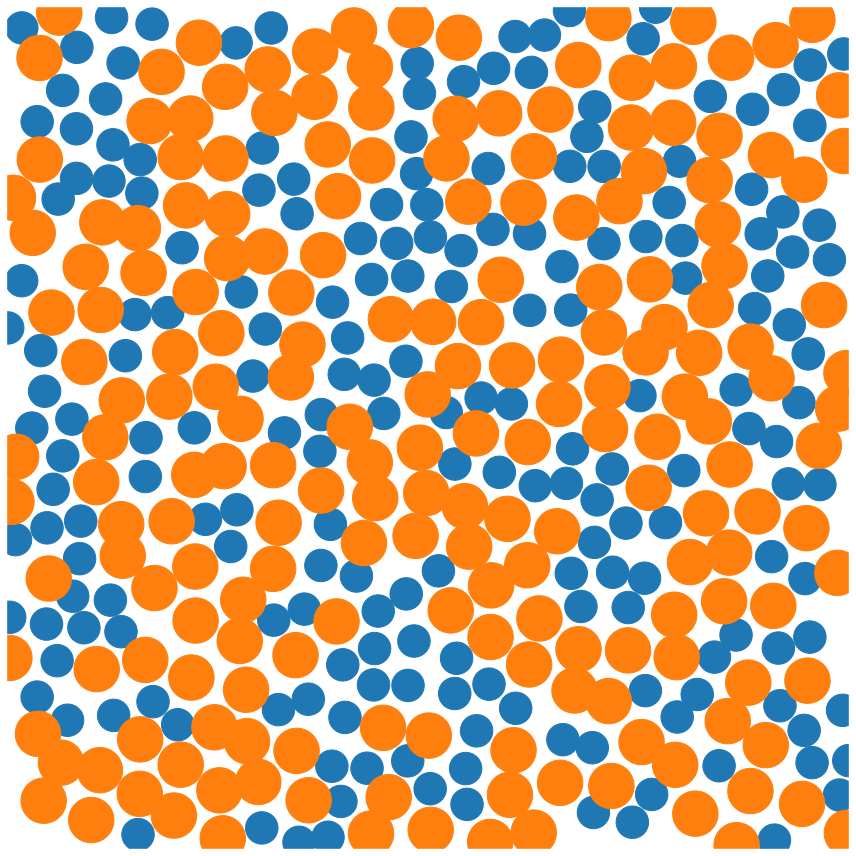

In [ ]:
ms = 65
R_plt = onp.array(log['position'][-1])

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, jnp.max(R_plt[:, 0])])
plt.ylim([0, jnp.max(R_plt[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can also draw an animation of the simulation using JAX MD's renderer. We see that the system starts out fluctuating about an initial larger box. When the pressure instantaneously changes, the box compresses the system.

In [ ]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = jnp.where(species[:, None], 
                  jnp.array([[1.0, 0.5, 0.01]]), 
                  jnp.array([[0.35, 0.65, 0.85]]))

renderer.render(box,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(700, 700))

## Larger Simulation with Neighbor Lists

##### **Warning: This section is a work in progress. We hope to make NPT + neighbor lists more ergonimic and safe in the future.**

We can use neighbor lists to run a much larger version of this simulation. As their name suggests, neighbor lists are lists of particles nearby a central particle. By keeping track of neighbors, we can compute the energy of the system much more efficiently. This becomes increasingly true as the simulation gets larger. Unlike other simulation environments, extra care must be taken with NPT simulations when using cell lists to construct neighbor lists (which is the default behavior). This is because the cells must be defined in the unit cube. As the system's volume changes, the effective size of cells will change. At some point, this may invalidate cell list, either because of buffer overflows or because the cells become too small to cover the desired neighborhood size. While we have error checking in the former case, we do not yet have checks for the latter. 

The code in this section therefore is to serve as an example for how neighbor lists + NPT might work. We expect to improve this section with time. If it is a priority for your work, please raise an issue.

As before, the first step here is to setup some simulation parameters. Unlike before, here we must be especially mindful of fluctuations in the box size. As such we will start out by creating the system and randomly initializing it. However, we will then minimize the system to its nearest minimum before starting the simulation.

In [ ]:
N = 10000
dt = 5e-3
box = quantity.box_size_at_number_density(N, 0.8, 2) * jnp.eye(2)
displacement, shift = space.periodic_general(box)

kT = jnp.float32(0.01)
P = lambda t: jnp.where(t < 100.0, 0.05, 0.07)

As before we randomly initialize the system.

In [ ]:
key, split = random.split(key)
R = random.uniform(split, (N, dimension), dtype=jnp.float64)

sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators. This time we use the `energy.soft_sphere_neighbor_fn` to create two functions: one that constructs lists of neighbors and one that computes the energy. Since we store the particle positions fractionally (in the unit cube), we must pass `fractional_coordinates=True` to the energy function.

In [ ]:
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box, species=species, sigma=sigma, fractional_coordinates=True)

init, apply = minimize.fire_descent(energy_fn, shift)

nbrs = neighbor_fn.allocate(R, extra_capacity=5)

state = init(R, neighbor=nbrs)

def cond_fn(state_nbrs):
  state, nbrs = state_nbrs
  return jnp.any(jnp.abs(state.force) > 1e-3)

def step_fn(state_nbrs):
  state, nbrs = state_nbrs
  state = apply(state, neighbor=nbrs)
  nbrs = nbrs.update(state.position)
  return state, nbrs

state, nbrs = lax.while_loop(cond_fn, step_fn, (state, nbrs))

print(f'Did buffer overflow: {nbrs.did_buffer_overflow}')
print(f'Pressure: {quantity.pressure(energy_fn, state.position, box, neighbor=nbrs)}')

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Did buffer overflow: [[0 0]
 [0 0]]
Pressure: 0.03154737754123678


Now we can plot the minimized configuration.

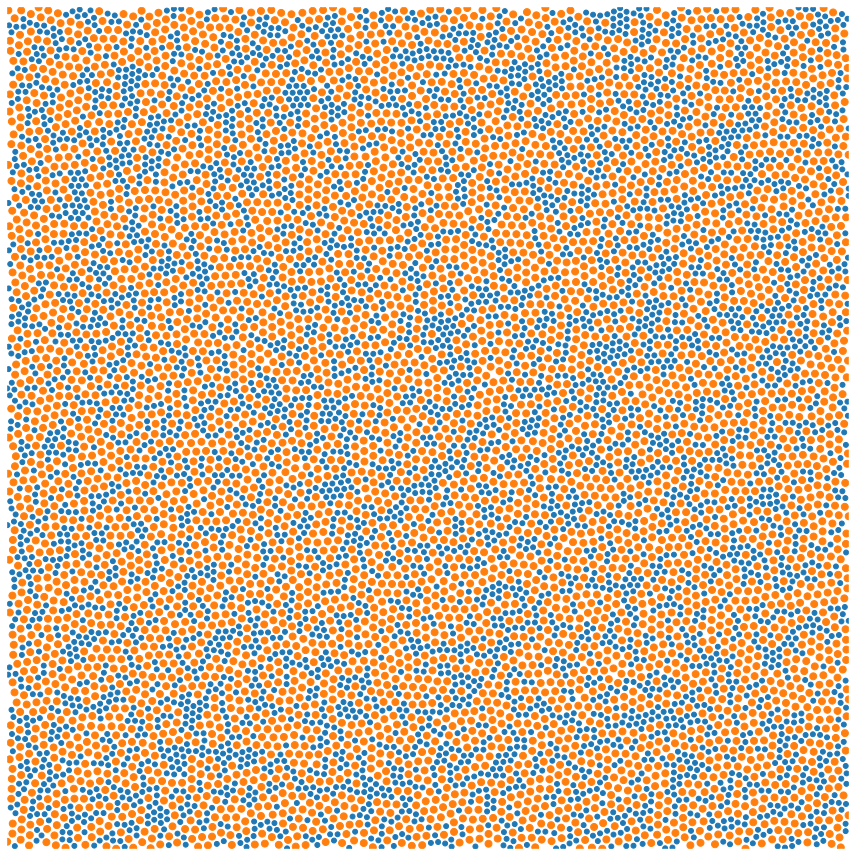

In [ ]:
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, jnp.max(R[:, 0])])
plt.ylim([0, jnp.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Now that we have a minimized configuration, we can do an NPT simulation. Since our cells have a fixed size, the neighbor list that we constructed will become invalid if the box is too small.

In [ ]:
init, apply = simulate.npt_nose_hoover(energy_fn, shift, dt, P(0.), kT)

nbrs = neighbor_fn.allocate(state.position)
state = init(key, state.position, box, neighbor=nbrs)

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Now let's actually do the simulation. This time our simulation step function will also update the neighbors. As above, we will also only record position data every hundred steps.

In [ ]:
write_every = 100

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)

  box = simulate.npt_box(state)
  KE = quantity.kinetic_energy(momentum=state.momentum)
  P_measured = quantity.pressure(energy_fn, state.position, box, KE, neighbor=nbrs)
  log['P'] = log['P'].at[i].set(P_measured)

  H = simulate.npt_nose_hoover_invariant(energy_fn, state, P(t), kT, neighbor=nbrs)
  log['H'] = log['H'].at[i].set(H)
  
  # Record positions every `write_every` steps.
  pos = space.transform(box, state.position)
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: p.at[i // write_every].set(pos), 
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, neighbor=nbrs, pressure=P(t))
  box = simulate.npt_box(state)
  nbrs = nbrs.update(state.position, box=box)
  
  return state, nbrs, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [ ]:
steps = 40000

log = {
    'P': jnp.zeros((steps,)),
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R.shape) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs, log))

print(nbrs.did_buffer_overflow)

R = state.position

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


[[2 2]
 [2 2]]


Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

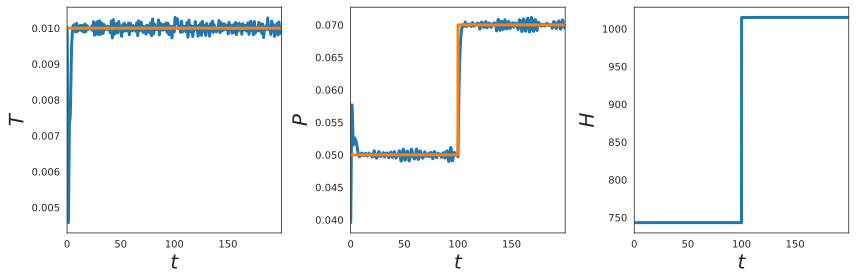

In [ ]:
plt.subplot(1, 3, 1)

t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT * jnp.ones_like(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$T$')

plt.subplot(1, 3, 2)

t = onp.arange(0, steps) * dt
plt.plot(t, log['P'], linewidth=3)
plt.plot(t, P(t), linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$P$')

plt.subplot(1, 3, 3)

t = onp.arange(0, steps) * dt
plt.plot(t, log['H'], linewidth=3)
plt.xlim([t[0], t[-1]])
format_plot('$t$', '$H$')

finalize_plot((2, 2 / 3))

Now let's plot a snapshot of the system.

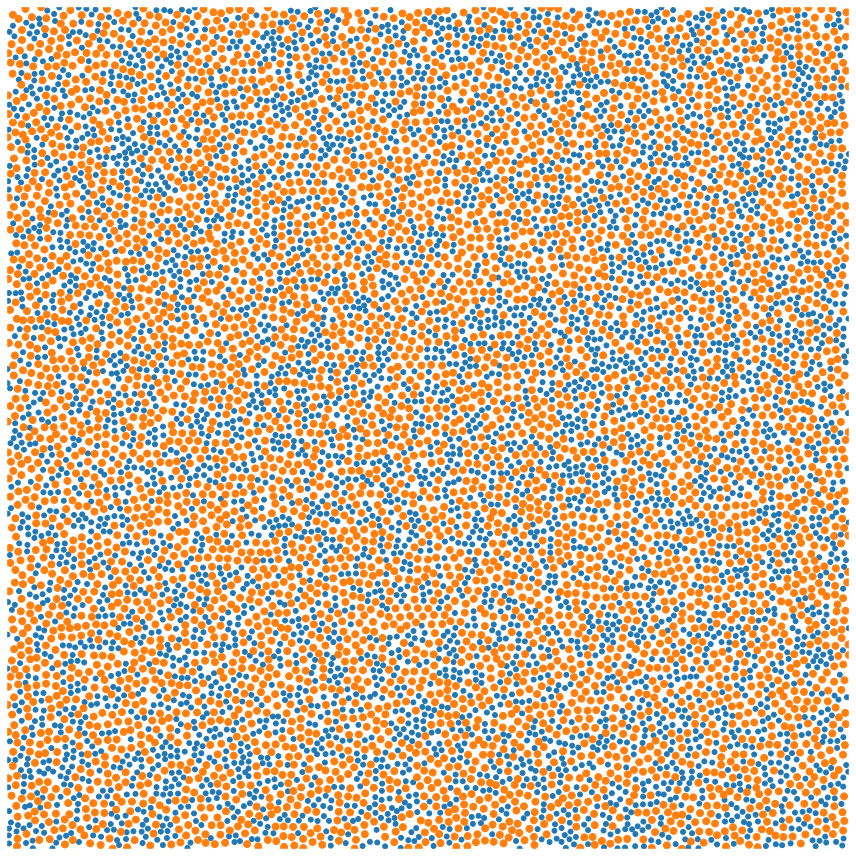

In [ ]:
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, jnp.max(R[:, 0])])
plt.ylim([0, jnp.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can also draw an animation of the simulation using JAX MD's renderer.

In [ ]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = jnp.where(species[:, None], 
                  jnp.array([[1.0, 0.5, 0.01]]), 
                  jnp.array([[0.35, 0.65, 0.85]]))

renderer.render(box[0, 0],
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                buffer_size=20,
                resolution=(700, 700))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [ ]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

<ipython-input-68-596f2703d7fc>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  occ, bins = onp.histogram(V_flat, bins=100, normed=True)


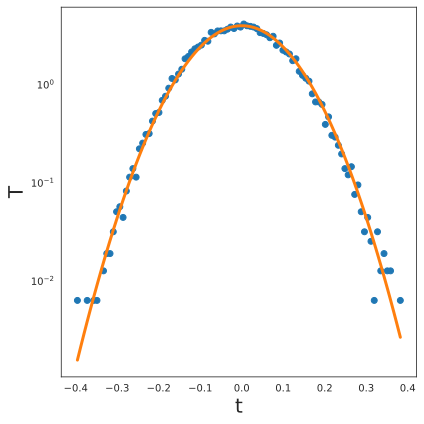

In [ ]:
T_cur = kT
plt.semilogy(bins[:-1], occ, 'o')
plt.semilogy(
    bins[:-1], 
    1.0 / jnp.sqrt(2 * jnp.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()